<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/catboost_amazon_resource_access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 26th May, 2022
# Data Source: https://www.kaggle.com/c/amazon-employee-access-challenge
# Ref: https://github.com/catboost/tutorials/blob/master/python_tutorial_with_tasks.ipynb
# Objective:
#             Predict an employee's access needs, given his/her job role
#

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb)

In this tutorial we will use dataset Amazon Employee Access Challenge from [Kaggle](https://www.kaggle.com) competition for our experiments. Data can be downloaded [here](https://www.kaggle.com/c/amazon-employee-access-challenge/data). But data is also available in catboost library. We will use the dataset available within catboost library. 

## Libraries installation

In [ ]:
!pip install --user --upgrade catboost
!pip install --user --upgrade ipywidgets

# SHAP (SHapley Additive exPlanations) is a game theoretic
#  approach to explain the output of any machine learning model.
# https://shap.readthedocs.io/en/latest/index.html
!pip install shap

!pip install sklearn
!pip install --upgrade numpy
!jupyter nbextension enable --py widgetsnbextension

In [2]:
# Check catboost and python versions
# Restart runtime if import fails:

import catboost           # 1.0.6
print(catboost.__version__)
!python --version         # 3.7.13

1.0.6
Python 3.7.13


In [55]:
# Call libraries
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets
import matplotlib.pyplot as plt
import os, time ,gc

In [7]:
# Display multiple command outputs from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Reading the data

In [25]:
# Load train/test data from catboost package:

(train_df, test_df) = catboost.datasets.amazon()

In [26]:
print("\n===dtypes===")
train_df.dtypes
print("\n===Shape ===")
train_df.shape
print("\n======")
train_df.head()


===dtypes===


ACTION              int64
RESOURCE            int64
MGR_ID              int64
ROLE_ROLLUP_1       int64
ROLE_ROLLUP_2       int64
ROLE_DEPTNAME       int64
ROLE_TITLE          int64
ROLE_FAMILY_DESC    int64
ROLE_FAMILY         int64
ROLE_CODE           int64
dtype: object


===Shape ===


(32769, 10)

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [27]:
for i in train_df.columns:
  print(i,": ", train_df[i].nunique())

ACTION :  2
RESOURCE :  7518
MGR_ID :  4243
ROLE_ROLLUP_1 :  128
ROLE_ROLLUP_2 :  177
ROLE_DEPTNAME :  449
ROLE_TITLE :  343
ROLE_FAMILY_DESC :  2358
ROLE_FAMILY :  67
ROLE_CODE :  343


## Transform all columns to category:

In [28]:
train_df.memory_usage().sum()/1000000   # 2.621648

2.621648

In [30]:
for i in train_df.columns:
  train_df[i] = train_df[i].astype('category')

In [31]:
train_df.memory_usage().sum()/1000000   # 1.22 MB

1.221142

## Preparing your data

### Transform all columns to category:

In [ ]:
train_df.memory_usage().sum()/1000000   # 2.621648

2.621648

In [ ]:
# To 'category'
for i in train_df.columns:
  train_df[i] = train_df[i].astype('category')

Label values extraction

In [32]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Categorical features declaration

In [33]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Looking on label balance in dataset

In [34]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


Ways to create Pool class

In [35]:
dataset_dir = './amazon'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# We will be able to work with files with/without header and
# with different separators.
train_df.to_csv(
    os.path.join(dataset_dir, 'train.tsv'),
    index=False, sep='\t', header=False
)

test_df.to_csv(
    os.path.join(dataset_dir, 'test.tsv'),
    index=False, sep='\t', header=False
)

train_df.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
)

test_df.to_csv(
    os.path.join(dataset_dir, 'test.csv'),
    index=False, sep=',', header=True
)

In [39]:
print("\n\n==train.csv==")
!head amazon/train.csv
print("\n\n==train.tsv==")
!head amazon/train.tsv


==train.csv==
ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
1,36724,14457,118219,118220,117884,117879,267952,19721,117880
1,36135,5396,117961,118343,119993,118321,240983,290919,118322
1,42680,5905,117929,117930,119569,119323,123932,19793,119325
0,45333,14561,117951,117952,118008,118568,118568,19721,118570
1,25993,17227,117961,118343,123476,118980,301534,118295,118982
1,19666,4209,117961,117969,118910,126820,269034,118638,126822
1,31246,783,117961,118413,120584,128230,302830,4673,128231

==train.tsv==
1	39353	85475	117961	118300	123472	117905	117906	290919	117908
1	17183	1540	117961	118343	123125	118536	118536	308574	118539
1	36724	14457	118219	118220	117884	117879	267952	19721	117880
1	36135	5396	117961	118343	119993	118321	240983	290919	118322
1	42680	5905	117929	117930	119569	119323	123932	19

In [45]:
feature_names = dict()
for column, name in enumerate(train_df.columns):
    if column == 0:
        continue
    feature_names[column - 1] = name
    
feature_names

{0: 'RESOURCE',
 1: 'MGR_ID',
 2: 'ROLE_ROLLUP_1',
 3: 'ROLE_ROLLUP_2',
 4: 'ROLE_DEPTNAME',
 5: 'ROLE_TITLE',
 6: 'ROLE_FAMILY_DESC',
 7: 'ROLE_FAMILY',
 8: 'ROLE_CODE'}

In [46]:
# Generate the columns description file with the given structure.
from catboost.utils import create_cd

In [47]:
help(create_cd)

Help on function create_cd in module catboost.utils:

create_cd(label=None, cat_features=None, embedding_features=None, weight=None, baseline=None, doc_id=None, group_id=None, subgroup_id=None, timestamp=None, auxiliary_columns=None, feature_names=None, output_path='train.cd')



In [48]:
create_cd(
         label=0, 
         cat_features=list(range(1, train_df.columns.shape[0])),
         feature_names=feature_names,
         output_path=os.path.join(dataset_dir, 'train.cd')
         )

In [49]:
!cat amazon/train.cd

0	Label	
1	Categ	RESOURCE
2	Categ	MGR_ID
3	Categ	ROLE_ROLLUP_1
4	Categ	ROLE_ROLLUP_2
5	Categ	ROLE_DEPTNAME
6	Categ	ROLE_TITLE
7	Categ	ROLE_FAMILY_DESC
8	Categ	ROLE_FAMILY
9	Categ	ROLE_CODE


In [ ]:
oos

In [70]:
# What is a Pool in catboost? 
# See StackOverflow here: https://stackoverflow.com/a/65852092/3282777
# Pool used in CatBoost as a data structure to train model from.
pool1 = Pool(data=X, label=y, cat_features=cat_features)

pool2 = Pool(
    data=os.path.join(dataset_dir, 'train.csv'), 
    delimiter=',', 
    column_description=os.path.join(dataset_dir, 'train.cd'),
    has_header=True
)

pool3 = Pool(data=X, cat_features=cat_features)

# Fastest way to create a Pool is to create it from numpy matrix.
# This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

#pool4 = Pool(
#    data=FeaturesData(
#        cat_feature_data=X_prepared,
#        cat_feature_names=list(X)
#    ),
#    label=y.values
#)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) +
      '\ndataset 2:' + str(pool2.shape) + 
      '\ndataset 3:' + str(pool3.shape)) 
      #'\ndataset 4: ' + str(pool4.shape))
    

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())
print('\ndataset 4:')
#print(pool4.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3:(32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 4:


## Split your data into train and validation

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

## Selecting the objective function

Possible options for binary classification:

`Logloss`

`CrossEntropy` for probabilities in target

In [52]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


## Stdout of the training

In [53]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
#     verbose=5,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.441257
0:	learn: 0.4220777	test: 0.4223741	best: 0.4223741 (0)	total: 20.7ms	remaining: 289ms
1:	learn: 0.3149660	test: 0.3151186	best: 0.3151186 (1)	total: 44.3ms	remaining: 288ms
2:	learn: 0.2621494	test: 0.2629766	best: 0.2629766 (2)	total: 61.6ms	remaining: 246ms
3:	learn: 0.2302316	test: 0.2302315	best: 0.2302315 (3)	total: 83.1ms	remaining: 228ms
4:	learn: 0.2060274	test: 0.2019603	best: 0.2019603 (4)	total: 101ms	remaining: 201ms
5:	learn: 0.1956107	test: 0.1894627	best: 0.1894627 (5)	total: 118ms	remaining: 177ms
6:	learn: 0.1870345	test: 0.1790904	best: 0.1790904 (6)	total: 136ms	remaining: 155ms
7:	learn: 0.1836943	test: 0.1748030	best: 0.1748030 (7)	total: 153ms	remaining: 134ms
8:	learn: 0.1807119	test: 0.1707896	best: 0.1707896 (8)	total: 169ms	remaining: 113ms
9:	learn: 0.1775777	test: 0.1662489	best: 0.1662489 (9)	total: 188ms	remaining: 93.8ms
10:	learn: 0.1762130	test: 0.1654446	best: 0.1654446 (10)	total: 210ms	remaining: 76.4ms
11:	learn: 0.176

## Metrics calculation and graph plotting

In [60]:
from google.colab import output
output.enable_custom_widget_manager()

In [61]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

plt.show()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Model comparison

In [62]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.01'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [63]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Best iteration

In [64]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [65]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 82


## Cross-validation

In [ ]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1695893693
bestIteration = 38

Training on fold [1/5]

bestTest = 0.164632916
bestIteration = 48

Training on fold [2/5]

bestTest = 0.15425211
bestIteration = 35

Training on fold [3/5]

bestTest = 0.1433537051
bestIteration = 55

Training on fold [4/5]

bestTest = 0.1560519524
bestIteration = 55



In [ ]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.302367,0.004317,0.302196,0.004517,0.513577,0.030360
1,1,0.227370,0.007679,0.228497,0.005126,0.642263,0.048004
2,2,0.190856,0.006917,0.196796,0.003999,0.791709,0.011361
3,3,0.178884,0.007455,0.186682,0.003242,0.813889,0.009362
4,4,0.172286,0.007957,0.181380,0.002135,0.826529,0.005319


In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1582±0.0102 on step 53


In [ ]:
cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1614486451
bestIteration = 31

Training on fold [1/5]

bestTest = 0.1551886688
bestIteration = 56

Training on fold [2/5]

bestTest = 0.1597838545
bestIteration = 25

Training on fold [3/5]

bestTest = 0.1523066165
bestIteration = 56

Training on fold [4/5]

bestTest = 0.1577738401
bestIteration = 30

Best validation Logloss score, stratified: 0.1580±0.0041 on step 56


## Overfitting detector

In [ ]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
print(model_with_early_stop.tree_count_)

30


In [ ]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
print(model_with_early_stop.tree_count_)

30


## Select decision boundary

In [ ]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [ ]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

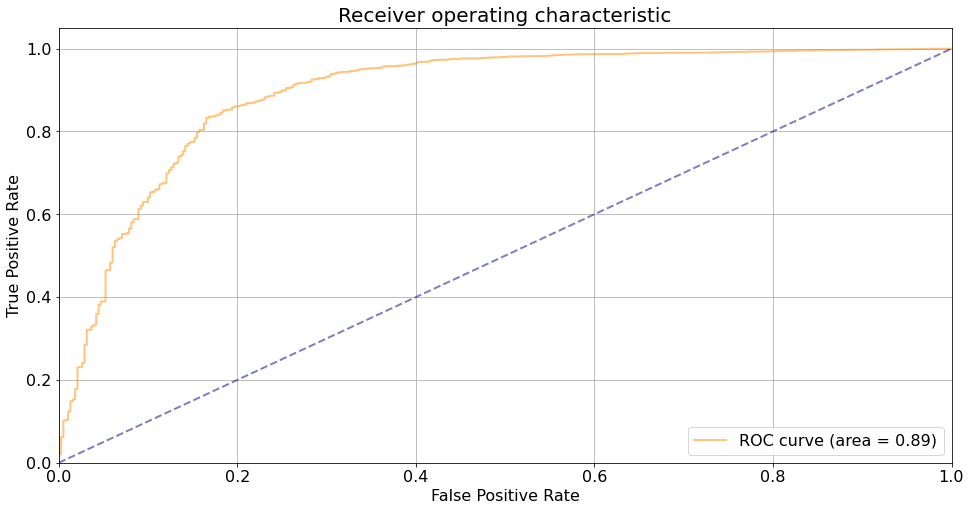

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

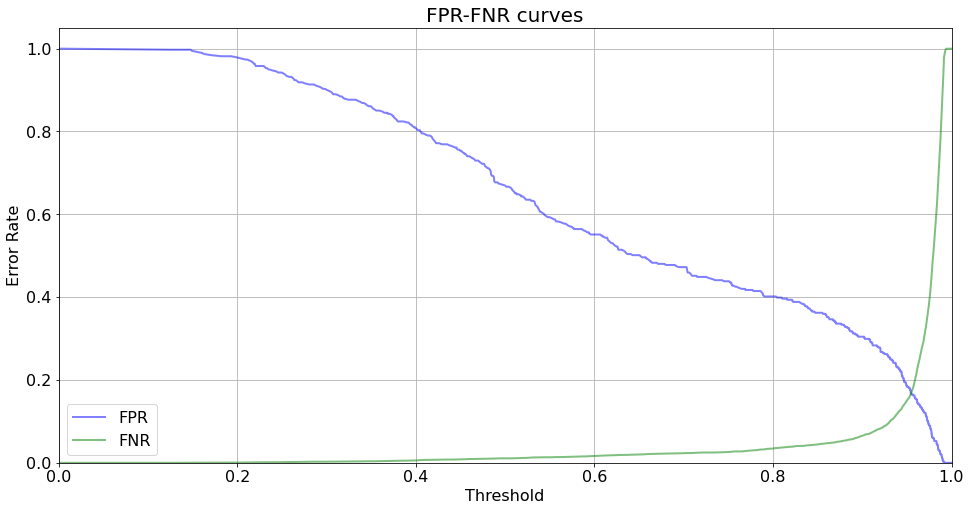

In [ ]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.4805444481363058
0.9900857295557712


## Snapshotting

In [ ]:
# !rm 'catboost_info/snapshot.bkp'
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1,
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=True
)

Learning rate set to 0.193326
0:	learn: 0.5565905	test: 0.5566217	best: 0.5566217 (0)	total: 14.8ms	remaining: 1.47s
1:	learn: 0.4642626	test: 0.4639935	best: 0.4639935 (1)	total: 26.7ms	remaining: 1.31s
2:	learn: 0.3989148	test: 0.3981304	best: 0.3981304 (2)	total: 44.5ms	remaining: 1.44s
3:	learn: 0.3516186	test: 0.3510286	best: 0.3510286 (3)	total: 53.3ms	remaining: 1.28s
4:	learn: 0.3164302	test: 0.3161297	best: 0.3161297 (4)	total: 71.5ms	remaining: 1.36s
5:	learn: 0.2906047	test: 0.2905494	best: 0.2905494 (5)	total: 78.1ms	remaining: 1.22s
6:	learn: 0.2710475	test: 0.2708899	best: 0.2708899 (6)	total: 86.5ms	remaining: 1.15s
7:	learn: 0.2538458	test: 0.2539798	best: 0.2539798 (7)	total: 108ms	remaining: 1.24s
8:	learn: 0.2399269	test: 0.2401350	best: 0.2401350 (8)	total: 128ms	remaining: 1.3s
9:	learn: 0.2298664	test: 0.2304173	best: 0.2304173 (9)	total: 147ms	remaining: 1.32s
10:	learn: 0.2180381	test: 0.2161946	best: 0.2161946 (10)	total: 166ms	remaining: 1.34s
11:	learn: 0.208

## Model predictions

In [ ]:
print(model.predict_proba(X=X_validation))

[[0.0508 0.9492]
 [0.0181 0.9819]
 [0.0179 0.9821]
 ...
 [0.0161 0.9839]
 [0.017  0.983 ]
 [0.0236 0.9764]]


In [ ]:
print(model.predict(data=X_validation))

[1 1 1 ... 1 1 1]


In [ ]:
raw_pred = model.predict(
    data=X_validation,
    prediction_type='RawFormulaVal'
)
print(raw_pred)

[2.9282 3.9947 4.0077 ... 4.1115 4.06   3.7207]


In [ ]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[0.9492 0.9819 0.9821 ... 0.9839 0.983  0.9764]


In [ ]:
X_prepared = X_validation.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

fast_predictions = model.predict_proba(
    X=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X_validation)
    )
)
print(fast_predictions)

[[0.0508 0.9492]
 [0.0181 0.9819]
 [0.0179 0.9821]
 ...
 [0.0161 0.9839]
 [0.017  0.983 ]
 [0.0236 0.9764]]


## Staged prediction

In [ ]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0, 
    ntree_end=5, 
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.4154 0.5846]
 [0.4154 0.5846]
 [0.4154 0.5846]
 ...
 [0.4154 0.5846]
 [0.4154 0.5846]
 [0.4154 0.5846]]
Iteration 1, predictions:
[[0.3476 0.6524]
 [0.3476 0.6524]
 [0.3476 0.6524]
 ...
 [0.3476 0.6524]
 [0.3476 0.6524]
 [0.3476 0.6524]]
Iteration 2, predictions:
[[0.292  0.708 ]
 [0.292  0.708 ]
 [0.2978 0.7022]
 ...
 [0.2978 0.7022]
 [0.292  0.708 ]
 [0.2978 0.7022]]
Iteration 3, predictions:
[[0.2485 0.7515]
 [0.2485 0.7515]
 [0.2538 0.7462]
 ...
 [0.2538 0.7462]
 [0.2485 0.7515]
 [0.2538 0.7462]]
Iteration 4, predictions:
[[0.2126 0.7874]
 [0.2126 0.7874]
 [0.2173 0.7827]
 ...
 [0.2173 0.7827]
 [0.2126 0.7874]
 [0.2173 0.7827]]


## Solving MultiClassification problem

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=43,
    loss_function='MultiClass'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

For multiclass problems with many classes sometimes it's better to solve classification problem using ranking.
To do that we will build a dataset with groups.
Every group will represent one object from our initial dataset.
But it will have one additional categorical feature - possible class value.
Target values will be equal to 1 if the class value is equal to the correct class, and 0 otherwise.
Thus each group will have exactly one 1 in labels, and some zeros.
You can put all possible class values in the group or you can try setting only hard negatives if there are too many labels.
We'll show this approach on an example of binary classification problem.

In [ ]:
from copy import deepcopy
def build_multiclass_ranking_dataset(X, y, cat_features, label_values=[0,1], start_group_id=0):
    ranking_matrix = []
    ranking_labels = []
    group_ids = []

    X_train_matrix = X.values
    y_train_vector = y.values

    for obj_idx in range(X.shape[0]):
        obj = list(X_train_matrix[obj_idx])

        for label in label_values:
            obj_of_given_class = deepcopy(obj)
            obj_of_given_class.append(label)
            ranking_matrix.append(obj_of_given_class)
            ranking_labels.append(float(y_train_vector[obj_idx] == label)) 
            group_ids.append(start_group_id + obj_idx)
        
    final_cat_features = deepcopy(cat_features)
    final_cat_features.append(X.shape[1]) # new feature that we are adding should be categorical.
    return Pool(ranking_matrix, ranking_labels, cat_features=final_cat_features, group_id = group_ids)

In [ ]:
from catboost import CatBoost
params = {'iterations':150, 'learning_rate':0.01, 'l2_leaf_reg':30, 'random_seed':0, 'loss_function':'QuerySoftMax'}

groupwise_train_pool = build_multiclass_ranking_dataset(X_train, y_train, cat_features, [0,1])
groupwise_eval_pool = build_multiclass_ranking_dataset(X_validation, y_validation, cat_features, [0,1], X_train.shape[0])

model = CatBoost(params)
model.fit(
    X=groupwise_train_pool,
    verbose=False,
    eval_set=groupwise_eval_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Doing predictions with ranking mode

In [ ]:
import math

obj = list(X_validation.values[0])
ratings = []
for label in [0,1]:
    obj_with_label = deepcopy(obj)
    obj_with_label.append(label)
    rating = model.predict([obj_with_label])[0]
    ratings.append(rating)
print('Raw values:', np.array(ratings))

def soft_max(values):
    return [math.exp(val) / sum([math.exp(val) for val in values]) for val in values]

print('Probabilities', np.array(soft_max(ratings)))

Raw values: [-0.471   0.4713]
Probabilities [0.2804 0.7196]


## Metric evaluation on a new dataset

In [ ]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=50
)

0:	learn: 0.6569860	total: 34.1ms	remaining: 6.78s
50:	learn: 0.1923495	total: 2.27s	remaining: 6.64s
100:	learn: 0.1653594	total: 4.82s	remaining: 4.72s
150:	learn: 0.1570631	total: 8.33s	remaining: 2.7s
199:	learn: 0.1538962	total: 11.7s	remaining: 0us


In [ ]:
metrics = model.eval_metrics(
    data=pool1,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
print('AUC values:')
print(np.array(metrics['AUC']))

AUC values:
[0.4998 0.538  0.5504 0.5888 0.6536 0.6515 0.6476 0.648  0.7117 0.731
 0.7277 0.7278 0.7299 0.7298 0.7275 0.7273 0.7336 0.735  0.7445 0.7606
 0.7627 0.7627 0.7731 0.7769 0.7866 0.7985 0.7986 0.8008 0.8004 0.8004
 0.8191 0.8357 0.8518 0.8666 0.8851 0.8855 0.8886 0.8931 0.8936 0.8991
 0.9033 0.9115 0.9126 0.9136 0.9148 0.9163 0.9177 0.9184 0.9206 0.9211
 0.9259 0.9289 0.9291 0.9324 0.9329 0.9334 0.9338 0.9358 0.937  0.9383
 0.9386 0.9385 0.939  0.9396 0.94   0.9401 0.941  0.9411 0.942  0.9425
 0.944  0.9457 0.9471 0.9479 0.9489 0.9499 0.9512 0.9522 0.9527 0.9533
 0.9537 0.9541 0.9543 0.9547 0.955  0.9553 0.9554 0.9558 0.9558 0.9563
 0.9575 0.9584 0.9592 0.9597 0.9603 0.961  0.9614 0.9617 0.962  0.9624
 0.9627 0.963  0.9634 0.964  0.9642 0.9644 0.9648 0.9649 0.9653 0.9655
 0.9657 0.9657 0.9658 0.966  0.9661 0.9662 0.9663 0.9665 0.9665 0.9666
 0.9667 0.9669 0.967  0.9675 0.968  0.9683 0.9689 0.9694 0.9699 0.9703
 0.9706 0.9709 0.9711 0.9715 0.9715 0.9718 0.9719 0.9719 0.9723 0.


## Feature importances

In [ ]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RESOURCE,22.459777
1,MGR_ID,17.115632
2,ROLE_DEPTNAME,16.054805
3,ROLE_ROLLUP_2,13.975879
4,ROLE_CODE,10.030076
5,ROLE_FAMILY_DESC,7.517166
6,ROLE_TITLE,6.526255
7,ROLE_FAMILY,3.704980
8,ROLE_ROLLUP_1,2.615430


## Shap values

In [ ]:
shap_values = model.get_feature_importance(pool1, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(32769, 9)


In [ ]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

In [ ]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[91,:], X.iloc[91,:])

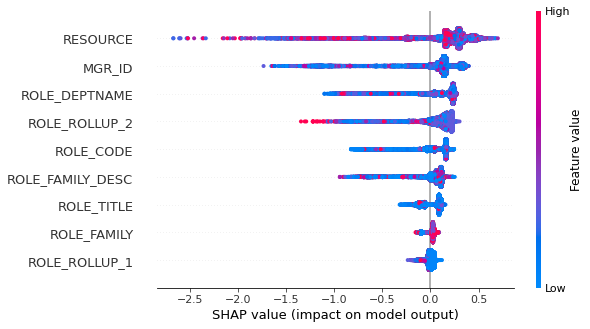

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
X_small = X.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(expected_value, shap_small, X_small)

## Feature evaluation

In [ ]:
from catboost.eval.catboost_evaluation import *
learn_params = {'iterations': 20, # 2000
                'learning_rate': 0.5, # we set big learning_rate,
                                      # because we have small
                                      # #iterations
                'random_seed': 0,
                'verbose': False,
                'loss_function' : 'Logloss',
                'boosting_type': 'Plain'}
evaluator = CatboostEvaluation('amazon/train.tsv',
                               fold_size=10000, # <= 50% of dataset
                               fold_count=20,
                               column_description='amazon/train.cd',
                               partition_random_seed=0,
                               #working_dir=... 
)
result = evaluator.eval_features(learn_config=learn_params,
                                 eval_metrics=['Logloss', 'Accuracy'],
                                 features_to_eval=[6, 7, 8])

In [ ]:
from catboost.eval.evaluation_result import *
logloss_result = result.get_metric_results('Logloss')
logloss_result.get_baseline_comparison(
    ScoreConfig(ScoreType.Rel, overfit_iterations_info=False)
)

,PValue,Score,Quantile 0.005,Quantile 0.995,Decision
Features: 6,0.000189,1.010962,0.527771,1.434171,GOOD
Features: 7,0.681322,-0.033237,-0.375103,0.308489,UNKNOWN
Features: 8,0.005111,-0.439271,-0.829381,-0.107245,BAD


## Saving the model

In [ ]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

In [ ]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0


## Hyperparameter tunning

### Training speed

In [ ]:
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Accuracy

In [ ]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton'
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Training the model after parameter tunning

In [ ]:
best_model = CatBoostClassifier(
    random_seed=63,
    iterations=int(tunned_model.tree_count_ * 1.2),
)
best_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=100
)

Learning rate set to 0.043372
0:	learn: 0.6422041	total: 32.6ms	remaining: 34.5s
100:	learn: 0.1537302	total: 6.2s	remaining: 58.9s
200:	learn: 0.1466783	total: 14.4s	remaining: 1m 1s
300:	learn: 0.1428331	total: 22.2s	remaining: 56s
400:	learn: 0.1389527	total: 30.5s	remaining: 50.1s
500:	learn: 0.1354927	total: 39s	remaining: 43.4s
600:	learn: 0.1327491	total: 47.4s	remaining: 36.1s
700:	learn: 0.1297104	total: 55.7s	remaining: 28.5s
800:	learn: 0.1270650	total: 1m 4s	remaining: 20.7s
900:	learn: 0.1243689	total: 1m 12s	remaining: 12.7s
1000:	learn: 0.1221292	total: 1m 21s	remaining: 4.7s
1058:	learn: 0.1207668	total: 1m 25s	remaining: 0us


## Calculate predictions for the contest

In [ ]:
X_test = test_df.drop('id', axis=1)
test_pool = Pool(data=X_test, cat_features=cat_features)
contest_predictions = best_model.predict_proba(test_pool)
print('Predictoins:')
print(contest_predictions)

Predictoins:
[[0.2754 0.7246]
 [0.0157 0.9843]
 [0.0101 0.9899]
 ...
 [0.0069 0.9931]
 [0.0561 0.9439]
 [0.0147 0.9853]]


## Prepare the submission

In [ ]:
f = open('submit.csv', 'w')
f.write('Id,Action\n')
for idx in range(len(contest_predictions)):
    line = str(test_df['id'][idx]) + ',' + str(contest_predictions[idx][1]) + '\n'
    f.write(line)
f.close()

Submit your solution [here](https://www.kaggle.com/c/amazon-employee-access-challenge/submit).
Good luck!!!